In [1]:
import torch
import torchvision
import PIL
import os
import random

import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm

# Architecture

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Loss Function

In [13]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        pdist  = nn.PairwiseDistance(p=2)
        euclidean_distance = pdist(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Data Loader

In [14]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Training

In [31]:
def train(train_dataloader):
    net = SiameseNetwork().cuda()
    criterion = ContrastiveLoss(1.)
    optimizer = optim.Adam(net.parameters(), lr = 0.0005)
    scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

    loss_history = []
    total_history = [] 
    current_loss = 0

    for epoch in range(20):
        for i, data in enumerate(train_dataloader):
            img0, img1 , label = data
            img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()

            output1,output2 = net(img0,img1)

            optimizer.zero_grad()
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            current_loss = loss_contrastive.data
            scheduler.step()
            if i %  10 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch,current_loss))
                loss_history.append(current_loss.cpu())
        
        total_history.append(np.mean(loss_history))
        loss_history = []

    return net, total_history

# Run Network

In [32]:
DATASET = '../../MIT_split'

t = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'train'), transform=t)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'test'), transform=t)

train_siamese_dataset = SiameseNetworkDataset(imageFolderDataset = train_dataset, transform=t,should_invert=False)
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset = test_dataset, transform=t,should_invert=False)

train_dataloader = torch.utils.data.DataLoader(train_siamese_dataset, num_workers=2, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_siamese_dataset, num_workers=2, batch_size=8, shuffle=True)

net, loss_history = train(train_dataloader)

Epoch number 0
 Current loss 0.3325495719909668

Epoch number 0
 Current loss 2.0925889015197754

Epoch number 0
 Current loss 11.100726127624512

Epoch number 0
 Current loss 10.464908599853516

Epoch number 0
 Current loss 6.105060577392578

Epoch number 0
 Current loss 11.698567390441895

Epoch number 0
 Current loss 7.184004783630371

Epoch number 0
 Current loss 5.799109935760498

Epoch number 0
 Current loss 5.823307991027832

Epoch number 0
 Current loss 7.348162651062012

Epoch number 0
 Current loss 4.293975830078125

Epoch number 0
 Current loss 4.09883451461792

Epoch number 0
 Current loss 3.618868589401245

Epoch number 0
 Current loss 3.0014681816101074

Epoch number 0
 Current loss 9.920907974243164

Epoch number 0
 Current loss 3.7958927154541016

Epoch number 0
 Current loss 9.993020057678223

Epoch number 0
 Current loss 1.5624487400054932

Epoch number 0
 Current loss 6.671578884124756

Epoch number 0
 Current loss 19.684940338134766

Epoch number 0
 Current loss 5.2

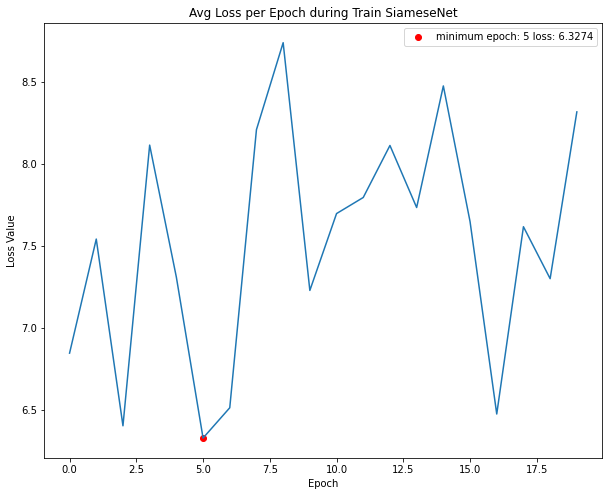

In [46]:
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Avg Loss per Epoch during Train SiameseNet")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(range(20), loss_history)
min_y = np.min(loss_history)
min_x = loss_history.index(min_y)
plt.scatter(min_x, min_y,c='r', label=f'minimum epoch: {min_x} loss: {min_y:.4f}')
plt.legend()
plt.show()